In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import sys 
!{sys.executable} -m pip install heartpy
import heartpy as hp
from sklearn import preprocessing
from heartpy.filtering import filter_signal

In [2]:
RawData1 = sio.loadmat( 'C:/Users/Bill/Desktop/report/Part_1.mat' )

In [3]:
RearrangedData = { 'ppg' : [] , 'diff1ppg' : [] , 'diff2ppg' : [] , 'abp' : []}
AttributeTable = { 'systolicIndex': [] , 'systolicValue': [] , 'hr': [] , 'valleyIndex0': [] , 'valleyValue0': [] , 'maxSlopeIndex': [] }
AttributeTable['maxSlopeIndex'] = []
AttributeTable['maxSlopeValue'] = []
AttributeTable['minSlopeIndex'] = []
AttributeTable['minSlopeValue'] = []
AttributeTable['peakValue1st'] = []
AttributeTable['valleyValue1st'] = []
AttributeTable['DicroticIndex'] = []
AttributeTable['DicroticValue'] = []
AttributeTable['peaIndex2st'] = []
AttributeTable['peakValue2st'] = []
AttributeTable['valleyIndex2st'] = []
AttributeTable['valleyValue2st'] = []
AttributeTable['DicroticDiff2Value'] = []
RearrangedData['SamplingRate'] = 125.0
AttributeTable['onsetIndex1st'] = []
AttributeTable['onsetValue1st'] = []
AttributeTable['onsetIndex2nd'] = []
AttributeTable['onsetValue2nd'] = []

In [4]:
for i in range( len(RawData1['Part_1'][0][0:20]) ):
    #Low pass filter
    N = len(RawData1['Part_1'][0][i][0])
    t = np.linspace( 0 , N , N )
    F = t*RearrangedData['SamplingRate']/N - RearrangedData['SamplingRate']/2
    yf = np.fft.fft( RawData1['Part_1'][0][i][0] )
    yf = np.fft.fftshift( yf )
    for i in range( N ):
        if ( F[i] > 10 ) | ( F[i] < -10 ):
            yf[i] = 0
    iyf = np.abs( np.fft.ifft( yf ) )

    #Nomarlization
    iyf = ( iyf - np.min(iyf) ) / ( max(iyf) - min(iyf) )
    RearrangedData['ppg'].append( iyf )


for i in range( len(RawData1['Part_1'][0][0:20]) ):
    RearrangedData['abp'].append( RawData1['Part_1'][0][i][1] )



for i in range( len(RearrangedData['ppg']) ):
    diff1 = []
    diff2 = []
    #Get and Filter 1st derivative ppg
    for j in range( 1 , len(RearrangedData['ppg'][i]) , 1 ):
        diff1.append( RearrangedData['ppg'][i][j] - RearrangedData['ppg'][i][j-1] )
    

    for k in range( 1 , len(diff1) , 1 ):
        diff2.append( diff1[k] - diff1[k-1] )
    
    diff1 = np.array( diff1 )
    diff2 = np.array( diff2 )
    RearrangedData['diff1ppg'].append( diff1 )
    RearrangedData['diff2ppg'].append( diff2 )
        


In [5]:
for i in range( len(RearrangedData['ppg']) ):
    #get peak index of ppg
    #temp = []
    working_data, measures = hp.process(RearrangedData['ppg'][i], 125.0)
    AttributeTable['systolicIndex'].append( np.setdiff1d( working_data['peaklist'] , working_data['removed_beats'] ) )
    temp = []
    for j in range( len(AttributeTable['systolicIndex'][i]) ):
        temp.append( RearrangedData['ppg'][i][AttributeTable['systolicIndex'][i][j]] ) 
    temp = np.array( temp )
    AttributeTable['systolicValue'].append(temp)

In [6]:
for x in range( len(AttributeTable['systolicIndex']) ):

    #Find the valleyIndex0 and valleyValue0
    minIndex = []
    minList = []
    for i in range( 1 , len(AttributeTable['systolicIndex'][x]) , 1 ):
        tempIndex = 0
        tempMin = 3
        for j in range( AttributeTable['systolicIndex'][x][i-1] ,  AttributeTable['systolicIndex'][x][i] , 1 ):
            if RearrangedData['ppg'][x][j] < tempMin:
                tempIndex = j
                tempMin = RearrangedData['ppg'][x][j]
        minIndex.append( tempIndex )
        minList.append( tempMin )
    minIndex = np.array( minIndex )
    minList = np.array( minList )
    AttributeTable['valleyIndex0'].append( minIndex )
    AttributeTable['valleyValue0'].append( minList )

    #Get hr 
    temphr = []
    for i in range( 1 , len( AttributeTable['valleyIndex0'][x] ) , 1 ):
        temphr.append( 60*125 / ( AttributeTable['valleyIndex0'][x][i] - AttributeTable['valleyIndex0'][x][i-1] ) )
    temphr = np.array( temphr )
    AttributeTable['hr'].append( temphr )    

In [7]:
for x in range( len(AttributeTable['valleyIndex0']) ):
    maxSlopeIndexList = []
    maxSlopeValueList = []
    minSlopeIndexList = []
    minSlopeValueList = []
    peakValue1stList = []
    valleyValue1stList = []
    DicroticIndexList = []
    DicroticValueList = []
    peakIndex2stList = []
    peakValue2stList = []
    valleyIndex2stList = []
    valleyValue2stList = []
    DicroticDiff2ValueList = []
    
    
    for i in range( 1 , len( AttributeTable['valleyIndex0'][x] ) , 1 ):
        maxSlope = -100
        maxSlopeIndex = 0
        minSlope = 100
        minSlopeIndex = 0
        
        peakvalue2st = -100
        peakindex2st = 0
        valleyvalue2st = 100
        valleyindex2st = 0
        
        for j in range( AttributeTable['valleyIndex0'][x][i-1] , AttributeTable['valleyIndex0'][x][i] , 1 ):
            if RearrangedData['diff1ppg'][x][j] > maxSlope:
                maxSlope = RearrangedData['diff1ppg'][x][j]
                maxSlopeIndex = j 
            if RearrangedData['diff2ppg'][x][j] > peakvalue2st:
                peakvalue2st = RearrangedData['diff2ppg'][x][j]
                peakindex2st = j
            if RearrangedData['diff2ppg'][x][j] < valleyvalue2st:
                valleyvalue2st = RearrangedData['diff2ppg'][x][j]
                valleyindex2st = j
            
            
            
        for j in range( AttributeTable['systolicIndex'][x][i] , int((AttributeTable['valleyIndex0'][x][i] + AttributeTable['systolicIndex'][x][i])/2) , 1 ):
            if RearrangedData['diff1ppg'][x][j] < minSlope:
                minSlope = RearrangedData['diff1ppg'][x][j]
                minSlopeIndex = j 
        maxSlopeIndexList.append( maxSlopeIndex )
        maxSlopeValueList.append( RearrangedData['ppg'][x][maxSlopeIndex] )
        minSlopeIndexList.append( minSlopeIndex )
        minSlopeValueList.append( RearrangedData['ppg'][x][minSlopeIndex] )
        peakValue1stList.append( maxSlope )
        valleyValue1stList.append( minSlope )
        peakIndex2stList.append( peakindex2st )
        peakValue2stList.append( peakvalue2st )
        valleyIndex2stList.append( valleyindex2st )
        valleyValue2stList.append( valleyvalue2st )
        
        


        maxdiff2 = -100
        maxdiff2Index = 0
        for k in range( minSlopeIndexList[i-1] , AttributeTable['valleyIndex0'][x][i] , 1 ):
            if RearrangedData['diff2ppg'][x][k-5] > maxdiff2:
                maxdiff2 = RearrangedData['diff2ppg'][x][k-5]
                maxdiff2Index = k - 5 
        DicroticIndexList.append( maxdiff2Index )
        DicroticValueList.append( RearrangedData['ppg'][x][maxdiff2Index+3] )
        DicroticDiff2ValueList.append( RearrangedData['diff2ppg'][x][maxdiff2Index] )
        
        
        

            



    maxSlopeIndexList = np.array( maxSlopeIndexList )
    maxSlopeValueList = np.array( maxSlopeValueList )
    minSlopeIndexList = np.array( minSlopeIndexList )
    minSlopeValueList = np.array( minSlopeValueList )
    peakValue1stList = np.array( peakValue1stList )
    valleyValue1stList = np.array( valleyValue1stList )
    DicroticIndexList = np.array( DicroticIndexList )
    DicroticValueList = np.array( DicroticValueList )
    peakIndex2stList = np.array( peakIndex2stList )
    peakValue2stList = np.array( peakValue2stList )
    valleyIndex2stList = np.array( valleyIndex2stList )
    valleyValue2stList = np.array( valleyValue2stList )
    DicroticDiff2ValueList = np.array( DicroticDiff2ValueList )

    AttributeTable['maxSlopeIndex'].append( maxSlopeIndexList )
    AttributeTable['maxSlopeValue'].append( maxSlopeValueList )
    AttributeTable['minSlopeIndex'].append( minSlopeIndexList )
    AttributeTable['minSlopeValue'].append( minSlopeValueList )
    AttributeTable['peakValue1st'].append( peakValue1stList )
    AttributeTable['valleyValue1st'].append( valleyValue1stList )
    AttributeTable['DicroticIndex'].append( DicroticIndexList )
    AttributeTable['DicroticValue'].append( DicroticValueList )
    AttributeTable['peaIndex2st'].append( peakIndex2stList )
    AttributeTable['peakValue2st'].append( peakValue2stList )
    AttributeTable['valleyIndex2st'].append( valleyIndex2stList )
    AttributeTable['valleyValue2st'].append( valleyValue2stList )
    AttributeTable['DicroticDiff2Value'].append( DicroticDiff2ValueList )

In [8]:
for x in range( len(AttributeTable['maxSlopeIndex']) ):


    onsetIndexList1st = []
    onsetValueList1st = []
    for i in range( 1 , len( AttributeTable['maxSlopeIndex'][x] ) , 1 ):

        onsetIndex = 0
        onsetValue = 0
        j = AttributeTable['maxSlopeIndex'][x][i] - 1
        while j > AttributeTable['DicroticIndex'][x][i-1]:
            slope1_r = RearrangedData['diff1ppg'][x][j+2] - RearrangedData['diff1ppg'][x][j]
            slope1_l = RearrangedData['diff1ppg'][x][j] - RearrangedData['diff1ppg'][x][j-2]
            #slope2_r = RearrangedData['diff1ppg'][x][j+1] - RearrangedData['diff1ppg'][x][j-1]
            #slope2_l = RearrangedData['diff1ppg'][x][j-1] - RearrangedData['diff1ppg'][x][j-3]

            if ( slope1_r > 0 ) and ( slope1_l < 0 ):# and ( slope2_r > 0 ) and ( slope2_l < 0 ):
                #if RearrangedData['diff1ppg'][x][j] < RearrangedData['diff1ppg'][x][j+1]:
                onsetIndex = j 
                onsetValue = RearrangedData['diff1ppg'][x][j]
                #else: 
                break
            j = j - 1
        onsetIndexList1st.append( onsetIndex )
        onsetValueList1st.append( onsetValue )


    onsetIndexList2nd = []
    onsetValueList2nd = []
    for i in range( 1 , len( AttributeTable['peaIndex2st'][x] ) , 1 ):

        onsetIndex = 0
        onsetValue = 0
        j = AttributeTable['peaIndex2st'][x][i] - 1
        while j >= AttributeTable['DicroticIndex'][x][i-1]:
            slope1_r = RearrangedData['diff2ppg'][x][j+2] - RearrangedData['diff2ppg'][x][j]
            slope1_l = RearrangedData['diff2ppg'][x][j] - RearrangedData['diff2ppg'][x][j-2]
            #slope2_r = RearrangedData['diff2ppg'][x][j+1] - RearrangedData['diff2ppg'][x][j-1]
            #slope2_l = RearrangedData['diff2ppg'][x][j-1] - RearrangedData['diff2ppg'][x][j-3]

            if ( slope1_r > 0 ) and ( slope1_l < 0 ): #and ( slope2_r > 0 ) and ( slope2_l < 0 ):
                #if RearrangedData['diff2ppg'][x][j] < RearrangedData['diff2ppg'][x][j+1]:
                onsetIndex = j 
                onsetValue = RearrangedData['diff2ppg'][x][j]
                #else: 
                break
            j = j - 1
        onsetIndexList2nd.append( onsetIndex )
        onsetValueList2nd.append( onsetValue )




    onsetIndexList1st = np.array( onsetIndexList1st )
    onsetValueList1st = np.array( onsetValueList1st )
    onsetIndexList2nd = np.array( onsetIndexList2nd )
    onsetValueList2nd = np.array( onsetValueList2nd )

    AttributeTable['onsetIndex1st'].append( onsetIndexList1st )
    AttributeTable['onsetValue1st'].append( onsetValueList1st )
    AttributeTable['onsetIndex2nd'].append( onsetIndexList2nd )
    AttributeTable['onsetValue2nd'].append( onsetValueList2nd )

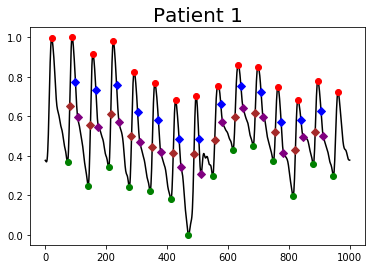

In [9]:
y = 13
Test = RearrangedData['ppg'][y]
t = np.linspace( 0 , len(Test) , len(Test) )

plt.plot( t , Test , color = 'black' , label = 'PPG' )
plt.plot( AttributeTable['systolicIndex'][y] , AttributeTable['systolicValue'][y]  , 'o' , color = 'red' , label = 'Peak' )
plt.plot( AttributeTable['valleyIndex0'][y] , AttributeTable['valleyValue0'][y]  , 'o' , color = 'green' , label = 'Valley' )
plt.plot( AttributeTable['DicroticIndex'][y]+3 , AttributeTable['DicroticValue'][y] , 'D' , color = 'purple' , label = 'Dicrotic Notch'  )
plt.plot( AttributeTable['maxSlopeIndex'][y] , AttributeTable['maxSlopeValue'][y] , 'D' , color = 'brown', label = 'Max Slope' )
plt.plot( AttributeTable['minSlopeIndex'][y] , AttributeTable['minSlopeValue'][y] , 'D' , color = 'blue' , label = 'Min Slope' )
#plt.legend( loc = 'best' )
plt.title( 'Patient 1' , fontsize = 20 , color = 'black' )
plt.show()


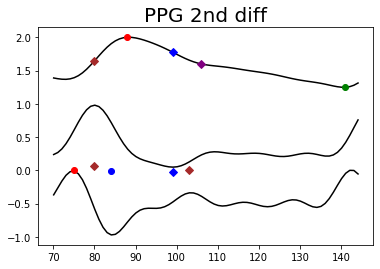

In [20]:
y = 13
Test = RearrangedData['ppg'][y]
Test = Test + 1
t = np.linspace( 0 , len(Test) , len(Test) )

plt.plot( t[70:145] , Test[70:145] , color = 'black' , label = 'PPG' )
plt.plot( AttributeTable['systolicIndex'][y][1] , AttributeTable['systolicValue'][y][1]+1  , 'o' , color = 'red' , label = 'Peak' )
plt.plot( AttributeTable['valleyIndex0'][y][1] , AttributeTable['valleyValue0'][y][1]+1  , 'o' , color = 'green' , label = 'Valley' )
plt.plot( AttributeTable['DicroticIndex'][y][0]+3 , AttributeTable['DicroticValue'][y][0]+1 , 'D' , color = 'purple' , label = 'Dicrotic Notch'  )
plt.plot( AttributeTable['maxSlopeIndex'][y][0] , AttributeTable['maxSlopeValue'][y][0]+1 , 'D' , color = 'brown', label = 'Max Slope' )
plt.plot( AttributeTable['minSlopeIndex'][y][0] , AttributeTable['minSlopeValue'][y][0]+1 , 'D' , color = 'blue' , label = 'Min Slope' )
plt.title( 'PPG' , fontsize = 20 , color = 'black')
#plt.legend( loc = 'best' )


Test1 = RearrangedData['diff1ppg'][y]
Test1 = ( Test1 - np.min( Test1 ) ) / ( np.max( Test1 ) - np.min( Test1 ) ) 
t1 = np.linspace( 0 , len(Test1) , len(Test1) )

plt.plot( t1[70:145] , Test1[70:145] , color = 'black' , label = '1st Diff' )
plt.plot( AttributeTable['maxSlopeIndex'][y][0] , ( AttributeTable['peakValue1st'][y][0] - np.min( Test1 ) ) / ( np.max( Test1 ) - np.min( Test1 ) ) , 'D' , color = 'brown' , label = 'Max Slope' )
plt.plot( AttributeTable['minSlopeIndex'][y][0] , ( AttributeTable['valleyValue1st'][y][0]- np.min( Test1 ) ) / ( np.max( Test1 ) - np.min( Test1 )  ) , 'D', color = 'blue' ,  label = 'Min Slope' )
#plt.legend( loc = 'best' )
plt.title( 'PPG 1st diff' , fontsize = 20 , color = 'black')

Test2 = RearrangedData['diff2ppg'][y]
Test2 = ( Test2 - np.min( Test2 ) ) / ( np.max( Test2 ) - np.min( Test2 ) )
Test2 = Test2 - 1
t2 = np.linspace( 0 , len(Test2) , len(Test2) )

plt.plot( t2[70:145] , Test2[70:145] , color = 'black' , label = '2nd Diff' )
plt.plot( AttributeTable['peaIndex2st'][y][0]  , ( AttributeTable['peakValue2st'][y][0] - np.min( Test2 ) ) / ( np.max( Test2 ) - np.min( Test2 ) ) - 1 , 'o' , color = 'red' , label = 'Max 2nd Diff' )
plt.plot( AttributeTable['valleyIndex2st'][y][0] ,( AttributeTable['valleyValue2st'][y][0]  - np.min( Test2 ) ) / ( np.max( Test2 ) - np.min( Test2 ) ) - 1, 'o' , color = 'blue' , label = 'Min 2nd Diff' )
plt.plot( AttributeTable['DicroticIndex'][y][0] , ( AttributeTable['DicroticDiff2Value'][y][0]  - np.min( Test2 ) ) / ( np.max( Test2 ) - np.min( Test2 ) ) - 1  , 'D' , color = 'brown' , label = 'Dicrotic Notch' )
#plt.legend( loc = 'best' )
plt.title( 'PPG 2nd diff' , fontsize = 20 , color = 'black')
plt.show()


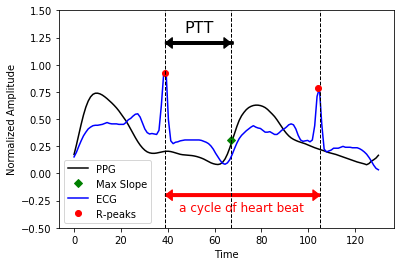

In [11]:
y = 12
Test = np.array( RawData1['Part_1'][0][y][0] )
Test = ( Test - np.min( Test ) ) / ( np.max( Test ) - np.min( Test ) )
Test = Test[300:430]
t = np.linspace( 0 , len(Test) , len(Test) )
plt.plot( t , Test , color = 'black' , label = 'PPG' )
plt.plot( AttributeTable['maxSlopeIndex'][y][4]-300 , AttributeTable['maxSlopeValue'][y][4] , 'D' , color = 'green', label = 'Max Slope' )
plt.axvline( x = AttributeTable['maxSlopeIndex'][y][4]-300 , color = 'black' , linestyle = '--' , linewidth = '1' )
Test2 = np.array( RawData1['Part_1'][0][y][2] )
Test2 = ( Test2 - np.min( Test2 ) ) / ( np.max( Test2 ) - np.min( Test2 ) )
working_data, measures = hp.process(Test2, 125.0)
ecg_ri = np.setdiff1d( working_data['peaklist'] , working_data['removed_beats'] )
ecg_rv = []
for i in range( len(ecg_ri) ):
    ecg_rv.append( Test2[ ecg_ri[i] ] )
ecg_rv = np.array( ecg_rv )
Test2 = Test2[330:460]
t2 = np.linspace( 0 , len(Test2) , len(Test2) )
plt.plot( t2 , Test2 , color = 'blue' , label = 'ECG' )
plt.plot( ecg_ri[4]-330+1 , ecg_rv[4] , 'o', color = 'red'  , label = 'R-peaks' )
plt.axvline( x = ecg_ri[4]-330+1 , color = 'black' , linestyle = '--' , linewidth = '1' )
plt.axvline( x = ecg_ri[5]-330+1 , color = 'black' , linestyle = '--' , linewidth = '1' )
plt.plot( ecg_ri[5]-330 , ecg_rv[5]+0.005 , 'o', color = 'red'  )
plt.xlabel( 'Time' )
plt.ylabel( 'Normalized Amplitude' )
plt.legend( loc = 'lower left' )
plt.ylim( ( -0.5 , 1.5 ) )


plt.arrow( ecg_ri[4]-330+1 , 1.2 , AttributeTable['maxSlopeIndex'][y][4] - ecg_ri[4] + 30 - 1 , 0 , width = 0.025 , shape = 'left' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'black' )
plt.arrow( ecg_ri[4]-330+1 , 1.2 , AttributeTable['maxSlopeIndex'][y][4] - ecg_ri[4] + 30 - 1 , 0 , width = 0.025 , shape = 'right' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'black' )
plt.arrow( AttributeTable['maxSlopeIndex'][y][4]-300+1  ,  1.2 , ecg_ri[4] - AttributeTable['maxSlopeIndex'][y][4] - 30 ,  0 , width = 0.025 , shape = 'left' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'black' )
plt.arrow( AttributeTable['maxSlopeIndex'][y][4]-300+1  ,  1.2 , ecg_ri[4] - AttributeTable['maxSlopeIndex'][y][4] - 30 ,  0 , width = 0.025 , shape = 'right' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'black' )



plt.arrow( ecg_ri[4]-330+1 , -0.2 , ecg_ri[5] - ecg_ri[4] , 0 , width = 0.025 , shape = 'left' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'red' )
plt.arrow( ecg_ri[4]-330+1 , -0.2 , ecg_ri[5] - ecg_ri[4] , 0 , width = 0.025 , shape = 'right' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'red' )
plt.arrow( ecg_ri[5]-330+1 , -0.2 , ecg_ri[4] - ecg_ri[5] ,  0 , width = 0.025 , shape = 'left' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'red' )
plt.arrow( ecg_ri[5]-330+1 , -0.2 , ecg_ri[4] - ecg_ri[5] ,  0 , width = 0.025 , shape = 'right' , length_includes_head = True , head_width = 0.1 , head_length = 3 , color = 'red' )


plt.annotate( 'a cycle of heart beat' , xy = ( 45 , -0.35 ) ,  xycoords='data', xytext=( 0 , 0 ) , textcoords='offset points', fontsize=12 , color = 'red' )
plt.annotate( 'PTT' , xy = ( 47 , 1.3 ) ,  xycoords='data', xytext=( 0 , 0 ) , textcoords='offset points', fontsize=16 , color = 'black' ) 
plt.show()

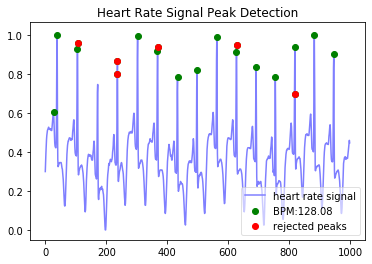

In [12]:
hp.plotter( working_data , measures ) 

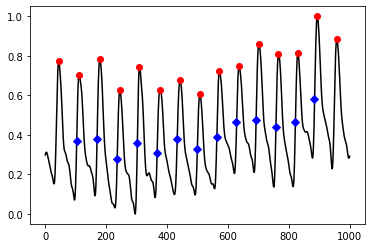

In [13]:
y = 12
Test0 = RearrangedData['ppg'][y]
t0 = np.linspace( 0 , len(Test0) , len(Test0) )

plt.plot( t0 , Test0 , color = 'black' , label = 'PPG' )
plt.plot( AttributeTable['systolicIndex'][y] , AttributeTable['systolicValue'][y]  , 'o' , color = 'red' , label = 'Peak' )
plt.plot( AttributeTable['maxSlopeIndex'][y] , AttributeTable['maxSlopeValue'][y] , 'D' , color = 'blue', label = 'Max Slope' )